In [1]:
from pathlib import Path
import os
import sys

main_directory = Path(os.path.abspath("")).parent
sys.path.append(str(main_directory))

## Create a JSSP problem instance

In [2]:
from queasars.job_shop_scheduling.problem_instances import Machine, Operation, Job, JobShopSchedulingProblemInstance

machines = (Machine(name="m1"), Machine(name="m2"), Machine(name="m3"))

j1op1 = Operation(name="j1op1", machine=machines[0], processing_duration=1)
j1op2 = Operation(name="j1op2", machine=machines[1], processing_duration=1)
j1op3 = Operation(name="j1op1", machine=machines[2], processing_duration=1)
job1 = Job(name="j1", operations=(j1op1, j1op2, j1op3))

j2op1 = Operation(name="j2op1", machine=machines[2], processing_duration=1)
j2op2 = Operation(name="j2op2", machine=machines[1], processing_duration=1)
j2op3 = Operation(name="j2op1", machine=machines[0], processing_duration=1)
job2 = Job(name="j2", operations=(j2op1, j2op2, j2op3))

j3op1 = Operation(name="j3op1", machine=machines[1], processing_duration=1)
j3op2 = Operation(name="j3op2", machine=machines[2], processing_duration=1)
job3 = Job(name="j3", operations=(j3op1, j3op2))

jssp_instance = JobShopSchedulingProblemInstance(name="jssp1", machines=machines, jobs=(job1, job2, job3))

print(jssp_instance)

jssp1
  Machines:
    m1
    m2
    m3
  Jobs:
    j1:
      j1op1(m1, 1)
      j1op2(m2, 1)
      j1op1(m3, 1)
    j2:
      j2op1(m3, 1)
      j2op2(m2, 1)
      j2op1(m1, 1)
    j3:
      j3op1(m2, 1)
      j3op2(m3, 1)


## Visualize the created problem instance (optional)

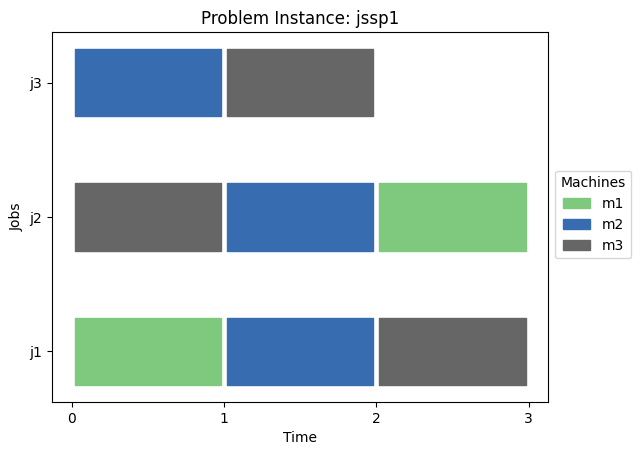

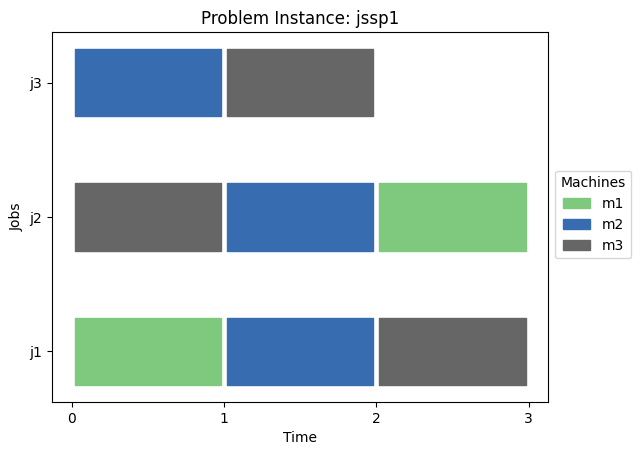

In [3]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_instance_gantt

plot_jssp_problem_instance_gantt(problem_instance=jssp_instance)

## Convert the problem instance to a hamiltonian

In [4]:
from queasars.job_shop_scheduling.domain_wall_hamiltonian_encoder import JSSPDomainWallHamiltonianEncoder

encoder = JSSPDomainWallHamiltonianEncoder(jssp_instance=jssp_instance, time_limit=4, penalty=100)

print("needed qubits: ", encoder.n_qubits)

hamiltonian = encoder.get_problem_hamiltonian()

needed qubits:  10


## Setup the configuration for the EVQEMinimumEigensolver

In [5]:
from dask.distributed import LocalCluster
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_algorithms.optimizers import SPSA

from queasars.minimum_eigensolvers.base.termination_criteria import BestIndividualRelativeImprovementTolerance
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolverConfiguration

# The EVQEMinimumEigensolver needs a sampler and can also use an estimator.
# Here we use the sampler and estimator provided by the qiskit_aer simulator.
sampler_primitive = Sampler()
estimator_primitive = Estimator()

# The EVQEMinimumEigensolver also needs a qiskit optimizer. It should be
# configured to terminate quickly, so that mutations are not overtly expensive.
# Here we use the SPSA optimizer with a very limited amount of iterations and a
# large step size.
optimizer = SPSA(maxiter=10, perturbation=0.2, learning_rate=0.2, trust_region=True)

# To help the EVQEMinimumEigensolver deal correctly with terminations based
# on the amount of circuit evaluations used, an estimate can be given for how
# many circuit evaluations the optimizer uses per optimization run.
# SPSA makes two measurements per iteration, which means in total it will
# need 20 circuit evaluations for 10 iterations.
optimizer_n_circuit_evaluations = 20

# An executor for launching parallel computation needs to be specified.
# This can be a dask Client or a python ThreadPoolExecutor. Dask will
# provide a significantly better performance but needs the Sampler and
# Estimator to be serializable by dask. On the other hand when using
# the ThreadPoolExecutor, the Sampler and Estimator need to be threadsafe.
# If this is not the case you can use the queasars.circuit_evaluation.mutex_primitives
# to wrap Samplers and Estimators to make them thread safe.
parallel_executor = LocalCluster(processes=True, n_workers=6).get_client()

# To specify when the EVQEMinimumEigensolver should terminate either max_generations,
# max_circuit_evaluations or a termination_criterion should be given.
# Here we choose to terminate once the best individual of a generation is less than 1% better than
# the best individual of the previous generation.
max_generations = None
max_circuit_evaluations = None
termination_criterion = BestIndividualRelativeImprovementTolerance(minimum_relative_improvement=0.01)

# A random seed can be provided to control the randomness of the evolutionary process.
random_seed = 0

# The population size determines how many individuals are evaluated each generation.
# With a higher population size, fewer generations might be needed, but this also
# makes each generation more expensive to evaluate. A reasonable range might be
# 10 - 100 individuals per population. Here we use a population size of 25.
population_size = 25

# If the optimization algorithm can't deal with parameter values of 0 at the beginning
# of the optimization, they can be randomized here. For this example we don't need this.
randomize_initial_population_parameters = False

# Determines how many circuit layers apart two individuals need to be, to be considered to
# be of a different species. Reasonable values might be in the range 2 - 5. Here we use 3.
speciation_genetic_distance_threshold = 3

# The alpha and beta penalties penalize quantum circuits of increasing depth (alpha) and
# increasing amount of controlled rotations (beta). increase them if the quantum circuits get to
# deep or complicated. For now we will use values of 0.1 for both penalties.
selection_alpha_penalty = 0.1
selection_beta_penalty = 0.1

# The parameter search probability determines how likely an individual is mutated by optimizing
# all it's parameter values. This should not be too large as this is costly. Here we will use
# a probability of 0.25.
parameter_search_probability = 0.25

# The topological search probability determines how likely a circuit layer is added to an individual
# as a mutation. This should be a higher probability to encourage exploration of different circuits.
# Here we will use a likelihood of 0.5
topological_search_probability = 0.5

# The layer removal probability determines how likely circuit layers are removed from an individual
# as a mutation. This is a very disruptive mutation and should only be used sparingly to counteract
# circuit growth. Here we will use a probability of 0.1
layer_removal_probability = 0.1

configuration = EVQEMinimumEigensolverConfiguration(
    sampler=sampler_primitive,
    estimator=estimator_primitive,
    optimizer=optimizer,
    optimizer_n_circuit_evaluations=optimizer_n_circuit_evaluations,
    parallel_executor=parallel_executor,
    max_generations=max_generations,
    max_circuit_evaluations=max_circuit_evaluations,
    termination_criterion=termination_criterion,
    random_seed=random_seed,
    population_size=population_size,
    randomize_initial_population_parameters=randomize_initial_population_parameters,
    speciation_genetic_distance_threshold=speciation_genetic_distance_threshold,
    selection_alpha_penalty=selection_alpha_penalty,
    selection_beta_penalty=selection_beta_penalty,
    parameter_search_probability=parameter_search_probability,
    topological_search_probability=topological_search_probability,
    layer_removal_probability=layer_removal_probability,
)

## Setup the EVQEMinimumEigensolver

In [6]:
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolver

eigensolver = EVQEMinimumEigensolver(configuration=configuration)

## Solve the problem as posed in the hamiltonian

In [7]:
import logging

logging.basicConfig(level=logging.INFO)

result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)
quasi_distribution = result.eigenstate.binary_probabilities()


INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 0
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: 665
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Average expectation value in the population currently: 711
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 1
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: 479
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Average expectation value in the population currently: 584
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 2
INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Expectation value of best individual found so far: 346
INFO:queasars.minimum_eigensolvers.base.

## Plot the distribution

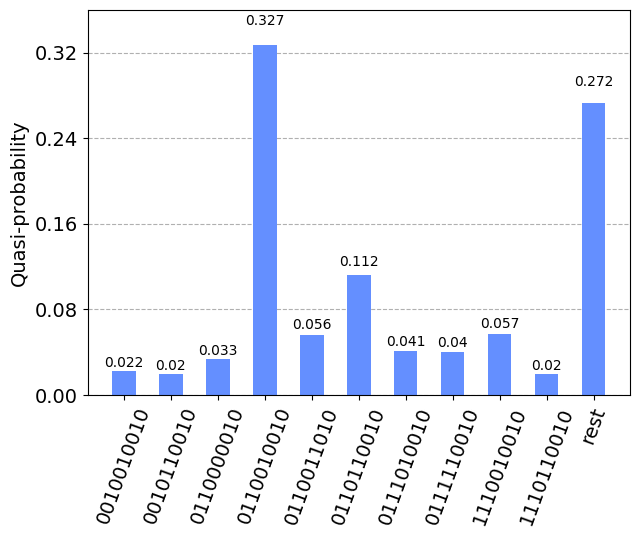

In [11]:
from qiskit.visualization import plot_distribution

plot_distribution(quasi_distribution, number_to_keep=10)

## use the encoder to retrieve the solution

In [15]:
solutions = []
for bitstring, probability in quasi_distribution.items():
    if probability < 0.1:
        continue

    solution = encoder.translate_result_bitstring(bitstring=bitstring)

    print("probability: ", probability)
    print(solution)
    solutions.append(solution)

probability:  0.3271484375
jssp1 solution with makespan 4
  j1:
    j1op1(m1, 1) starts at: 0 and ends at: 1
    j1op2(m2, 1) starts at: 2 and ends at: 3
    j1op1(m3, 1) starts at: 3 and ends at: 4
  j2:
    j2op1(m3, 1) starts at: 0 and ends at: 1
    j2op2(m2, 1) starts at: 1 and ends at: 2
    j2op1(m1, 1) starts at: 3 and ends at: 4
  j3:
    j3op1(m2, 1) starts at: 0 and ends at: 1
    j3op2(m3, 1) starts at: 2 and ends at: 3

probability:  0.1123046875
jssp1 solution with makespan 4
  j1:
    j1op1(m1, 1) starts at: 0 and ends at: 1
    j1op2(m2, 1) starts at: 2 and ends at: 3
    j1op1(m3, 1) starts at: 3 and ends at: 4
  j2:
    j2op1(m3, 1) starts at: 0 and ends at: 1
    j2op2(m2, 1) starts at: 2 and ends at: 3
    j2op1(m1, 1) starts at: 3 and ends at: 4
  j3:
    j3op1(m2, 1) starts at: 0 and ends at: 1
    j3op2(m3, 1) starts at: 2 and ends at: 3


## Visualize the result (optional)

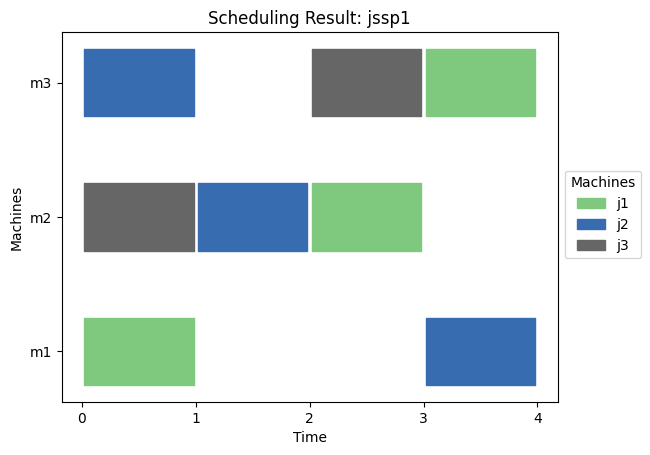

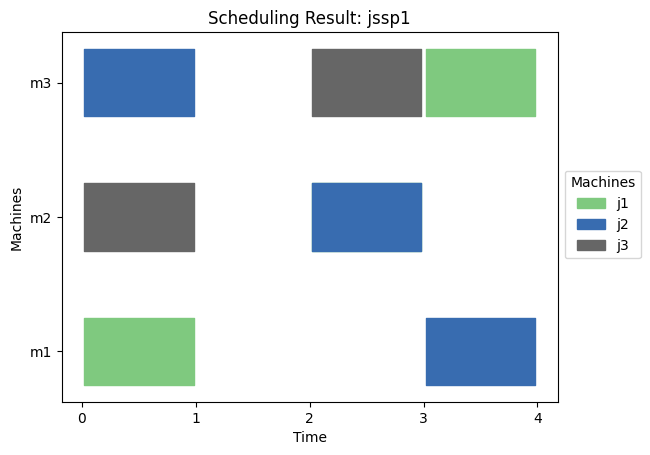

In [16]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_solution_gantt

for solution in solutions:
    plot = plot_jssp_problem_solution_gantt(result=solution)